In [1]:
# Enhanced Animal Classification ML Project
# Advanced Feature Engineering + Multiple Algorithms
# Target: >90% Accuracy with Data Augmentation & Ensemble Methods

import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support)
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from skimage import feature, filters, measure
from scipy import ndimage
import itertools

warnings.filterwarnings('ignore')
plt.style.use('default')
np.random.seed(42)

print("🚀 ENHANCED ANIMAL CLASSIFICATION PROJECT")
print("="*60)
print("🔧 Advanced Feature Engineering")
print("🤖 Multiple ML Algorithms (RF/SVM/KNN/GB)")
print("📈 Data Augmentation & Ensemble Methods")
print("🎯 Target: >90% Accuracy")
print("="*60)



🚀 ENHANCED ANIMAL CLASSIFICATION PROJECT
🔧 Advanced Feature Engineering
🤖 Multiple ML Algorithms (RF/SVM/KNN/GB)
📈 Data Augmentation & Ensemble Methods
🎯 Target: >90% Accuracy


In [2]:
# =============================================================================
# CELL 1: Enhanced Data Loading with Augmentation
# =============================================================================

def apply_data_augmentation(image):
    """Apply data augmentation to increase dataset size"""
    augmented_images = [image]  # Original image
    
    # Rotation
    for angle in [15, -15, 30, -30]:
        center = (image.shape[1]//2, image.shape[0]//2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        augmented_images.append(rotated)
    
    # Flipping
    flipped_h = cv2.flip(image, 1)  # Horizontal flip
    flipped_v = cv2.flip(image, 0)  # Vertical flip
    augmented_images.extend([flipped_h, flipped_v])
    
    # Brightness adjustment
    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=20)
    dark = cv2.convertScaleAbs(image, alpha=0.8, beta=-20)
    augmented_images.extend([bright, dark])
    
    # Gaussian blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images.append(blurred)
    
    return augmented_images

def load_enhanced_dataset(dataset_path='/kaggle/input/animalclassification/datset_new', 
                         target_size=(128, 128), apply_augmentation=True):
    """Load dataset with enhanced preprocessing and augmentation"""
    
    print("\n📁 ENHANCED DATASET LOADING")
    print("-" * 35)
    
    classes = ['dog', 'cow', 'cat', 'lamb', 'zebra']
    images = []
    labels = []
    
    dataset_path = Path(dataset_path)
    
    print(f"Dataset path: {dataset_path}")
    print(f"Target size: {target_size}")
    print(f"Data augmentation: {'ON' if apply_augmentation else 'OFF'}")
    
    if not dataset_path.exists():
        print(f"❌ Dataset not found at {dataset_path}")
        return None, None
    
    total_original = 0
    total_augmented = 0
    
    for class_name in classes:
        class_path = dataset_path / class_name
        
        if not class_path.exists():
            print(f"⚠️  Class '{class_name}' not found")
            continue
            
        # Get image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        image_files = []
        for ext in image_extensions:
            image_files.extend(class_path.glob(f'*{ext}'))
            image_files.extend(class_path.glob(f'*{ext.upper()}'))
        
        original_count = len(image_files)
        total_original += original_count
        
        print(f"📸 {class_name.capitalize()}: {original_count} original images")
        
        # Load and process images
        class_images = []
        for img_path in image_files:
            try:
                img = cv2.imread(str(img_path))
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, target_size)
                    
                    if apply_augmentation:
                        # Apply augmentation
                        augmented = apply_data_augmentation(img)
                        for aug_img in augmented:
                            # Normalize
                            norm_img = aug_img.astype(np.float32) / 255.0
                            class_images.append(norm_img)
                    else:
                        norm_img = img.astype(np.float32) / 255.0
                        class_images.append(norm_img)
                        
            except Exception as e:
                print(f"⚠️  Error loading {img_path.name}: {e}")
                continue
        
        # Add to main dataset
        images.extend(class_images)
        labels.extend([class_name] * len(class_images))
        
        augmented_count = len(class_images)
        total_augmented += augmented_count
        print(f"   ✅ Total after augmentation: {augmented_count} images")
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Original images: {total_original}")
    print(f"   After augmentation: {total_augmented}")
    print(f"   Augmentation factor: {total_augmented/total_original:.1f}x")
    
    if len(images) == 0:
        return None, None
    
    X = np.array(images)
    y = np.array(labels)
    
    print(f"📐 Final shape: {X.shape}")
    return X, y

# Load enhanced dataset
X_raw, y_raw = load_enhanced_dataset(apply_augmentation=True)

if X_raw is None:
    print("❌ Failed to load dataset")
else:
    print(f"✅ Dataset loaded: {len(X_raw)} samples")



📁 ENHANCED DATASET LOADING
-----------------------------------
Dataset path: /kaggle/input/animalclassification/datset_new
Target size: (128, 128)
Data augmentation: ON
📸 Dog: 105 original images
   ✅ Total after augmentation: 1050 images
📸 Cow: 101 original images
   ✅ Total after augmentation: 1010 images
📸 Cat: 109 original images
   ✅ Total after augmentation: 1090 images
📸 Lamb: 107 original images
   ✅ Total after augmentation: 1070 images
📸 Zebra: 108 original images
   ✅ Total after augmentation: 1080 images

📊 Dataset Summary:
   Original images: 530
   After augmentation: 5300
   Augmentation factor: 10.0x
📐 Final shape: (5300, 128, 128, 3)
✅ Dataset loaded: 5300 samples


In [3]:
# =============================================================================
# CELL 2: Advanced Feature Engineering
# =============================================================================

def extract_advanced_features(images):
    """Extract comprehensive features from images"""
    
    print("\n🎨 ADVANCED FEATURE ENGINEERING")
    print("-" * 40)
    
    features_list = []
    
    for i, img in enumerate(images):
        if i % 500 == 0:
            print(f"Processing image {i+1}/{len(images)}...")
        
        feature_vector = []
        
        # Convert to different color spaces
        img_uint8 = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        hsv = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
        
        # 1. Color Statistics (RGB, HSV, LAB)
        for channel in range(3):
            # RGB stats
            feature_vector.extend([
                np.mean(img[:, :, channel]),
                np.std(img[:, :, channel]),
                np.median(img[:, :, channel]),
                np.min(img[:, :, channel]),
                np.max(img[:, :, channel])
            ])
            
            # HSV stats
            feature_vector.extend([
                np.mean(hsv[:, :, channel]),
                np.std(hsv[:, :, channel])
            ])
            
            # LAB stats
            feature_vector.extend([
                np.mean(lab[:, :, channel]),
                np.std(lab[:, :, channel])
            ])
        
        # 2. Texture Features using LBP (Local Binary Patterns)
        try:
            lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10))
            lbp_hist = lbp_hist.astype(float)
            lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalize
            feature_vector.extend(lbp_hist)
        except:
            feature_vector.extend([0] * 10)
        
        # 3. Edge Features
        try:
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / edges.size
            feature_vector.append(edge_density)
            
            # Sobel gradients
            grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
            feature_vector.extend([
                np.mean(gradient_magnitude),
                np.std(gradient_magnitude)
            ])
        except:
            feature_vector.extend([0, 0, 0])
        
        # 4. Shape Features
        try:
            # Moments
            moments = cv2.moments(gray)
            if moments['m00'] != 0:
                hu_moments = cv2.HuMoments(moments).flatten()
                feature_vector.extend(hu_moments[:4])  # First 4 Hu moments
            else:
                feature_vector.extend([0] * 4)
        except:
            feature_vector.extend([0] * 4)
        
        # 5. Histogram Features (more detailed)
        for channel in range(3):
            hist, _ = np.histogram(img[:, :, channel], bins=16, range=(0, 1))
            hist = hist.astype(float)
            hist /= (hist.sum() + 1e-7)
            feature_vector.extend(hist)
        
        # 6. Contrast and Homogeneity
        try:
            contrast = np.std(gray)
            homogeneity = 1.0 / (1.0 + np.var(gray))
            feature_vector.extend([contrast, homogeneity])
        except:
            feature_vector.extend([0, 0])
        
        features_list.append(feature_vector)
    
    features_array = np.array(features_list)
    print(f"✅ Extracted features shape: {features_array.shape}")
    print(f"📊 Features per image: {features_array.shape[1]}")
    
    return features_array

# Extract advanced features
if X_raw is not None:
    print("🔧 Extracting advanced features...")
    X_features = extract_advanced_features(X_raw)
    print(f"✅ Feature extraction completed!")


🔧 Extracting advanced features...

🎨 ADVANCED FEATURE ENGINEERING
----------------------------------------
Processing image 1/5300...
Processing image 501/5300...
Processing image 1001/5300...
Processing image 1501/5300...
Processing image 2001/5300...
Processing image 2501/5300...
Processing image 3001/5300...
Processing image 3501/5300...
Processing image 4001/5300...
Processing image 4501/5300...
Processing image 5001/5300...
✅ Extracted features shape: (5300, 94)
📊 Features per image: 94
✅ Feature extraction completed!


In [5]:
# =============================================================================
# CELL 3: Enhanced Data Splits and Preprocessing
# =============================================================================

def create_enhanced_splits(X, y, test_size=0.15, val_size=0.15):
    """Create stratified splits with proper preprocessing"""
    
    print(f"\n📊 CREATING ENHANCED DATA SPLITS")
    print("-" * 40)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Create splits
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )
    
    val_size_adj = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adj, random_state=42, stratify=y_temp
    )
    
    print(f"📈 Data splits:")
    print(f"   Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
    print(f"   Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

def apply_advanced_preprocessing(X_train, X_val, X_test, n_components=500):
    """Apply scaling, feature selection, and PCA"""
    
    print(f"\n⚙️  ADVANCED PREPROCESSING")
    print("-" * 30)
    
    # 1. Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("✅ StandardScaler applied")
    
    # 2. Feature Selection (remove low-variance features)
    from sklearn.feature_selection import VarianceThreshold
    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var = variance_selector.fit_transform(X_train_scaled)
    X_val_var = variance_selector.transform(X_val_scaled)
    X_test_var = variance_selector.transform(X_test_scaled)
    print(f"✅ Variance selection: {X_train_scaled.shape[1]} → {X_train_var.shape[1]} features")
    
    # 3. PCA
    n_components = min(n_components, X_train_var.shape[1], X_train_var.shape[0] - 1)
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_var)
    X_val_pca = pca.transform(X_val_var)
    X_test_pca = pca.transform(X_test_var)
    
    explained_var = np.sum(pca.explained_variance_ratio_)
    print(f"✅ PCA: {X_train_var.shape[1]} → {n_components} components")
    print(f"📊 Explained variance: {explained_var:.3f} ({explained_var*100:.1f}%)")
    
    return (X_train_pca, X_val_pca, X_test_pca, 
            scaler, variance_selector, pca)

# Create splits and preprocess
if X_raw is not None:
    X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = create_enhanced_splits(
        X_features, y_raw
    )
    
    X_train_final, X_val_final, X_test_final, scaler, var_selector, pca = apply_advanced_preprocessing(
        X_train, X_val, X_test
    )



📊 CREATING ENHANCED DATA SPLITS
----------------------------------------
📈 Data splits:
   Train: 3710 (70.0%)
   Val:   795 (15.0%)
   Test:  795 (15.0%)

⚙️  ADVANCED PREPROCESSING
------------------------------
✅ StandardScaler applied
✅ Variance selection: 94 → 94 features
✅ PCA: 94 → 94 components
📊 Explained variance: 1.000 (100.0%)


In [6]:
# =============================================================================
# CELL 4: Multiple Algorithm Training with Hyperparameter Tuning
# =============================================================================

def train_multiple_algorithms(X_train, y_train, X_val, y_val):
    """Train and compare multiple algorithms"""
    
    print(f"\n🤖 TRAINING MULTIPLE ALGORITHMS")
    print("-" * 40)
    
    models = {}
    results = {}
    
    # 1. Random Forest
    print("🌲 Training Random Forest...")
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
    rf_grid.fit(X_train, y_train)
    
    models['Random Forest'] = rf_grid.best_estimator_
    val_pred_rf = rf_grid.predict(X_val)
    results['Random Forest'] = accuracy_score(y_val, val_pred_rf)
    print(f"   ✅ RF Validation Accuracy: {results['Random Forest']:.4f}")
    
    # 2. SVM
    print("🔍 Training SVM...")
    svm_params = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
    svm = SVC(random_state=42, probability=True)
    svm_grid = GridSearchCV(svm, svm_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
    svm_grid.fit(X_train, y_train)
    
    models['SVM'] = svm_grid.best_estimator_
    val_pred_svm = svm_grid.predict(X_val)
    results['SVM'] = accuracy_score(y_val, val_pred_svm)
    print(f"   ✅ SVM Validation Accuracy: {results['SVM']:.4f}")
    
    # 3. Gradient Boosting
    print("⚡ Training Gradient Boosting...")
    gb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5]
    }
    gb = GradientBoostingClassifier(random_state=42)
    gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
    gb_grid.fit(X_train, y_train)
    
    models['Gradient Boosting'] = gb_grid.best_estimator_
    val_pred_gb = gb_grid.predict(X_val)
    results['Gradient Boosting'] = accuracy_score(y_val, val_pred_gb)
    print(f"   ✅ GB Validation Accuracy: {results['Gradient Boosting']:.4f}")
    
    # 4. Enhanced Logistic Regression
    print("📊 Training Logistic Regression...")
    lr_params = {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [1000]
    }
    lr = LogisticRegression(random_state=42, multi_class='ovr')
    lr_grid = GridSearchCV(lr, lr_params, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
    lr_grid.fit(X_train, y_train)
    
    models['Logistic Regression'] = lr_grid.best_estimator_
    val_pred_lr = lr_grid.predict(X_val)
    results['Logistic Regression'] = accuracy_score(y_val, val_pred_lr)
    print(f"   ✅ LR Validation Accuracy: {results['Logistic Regression']:.4f}")
    
    # 5. Ensemble (Voting Classifier)
    print("🎭 Creating Ensemble...")
    ensemble = VotingClassifier([
        ('rf', models['Random Forest']),
        ('svm', models['SVM']),
        ('gb', models['Gradient Boosting']),
        ('lr', models['Logistic Regression'])
    ], voting='soft')
    
    ensemble.fit(X_train, y_train)
    models['Ensemble'] = ensemble
    val_pred_ensemble = ensemble.predict(X_val)
    results['Ensemble'] = accuracy_score(y_val, val_pred_ensemble)
    print(f"   ✅ Ensemble Validation Accuracy: {results['Ensemble']:.4f}")
    
    # Select best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    best_score = results[best_model_name]
    
    print(f"\n BEST MODEL: {best_model_name}")
    print(f"📊 Best Validation Score: {best_score:.4f} ({best_score*100:.2f}%)")
    
    return models, results, best_model, best_model_name

# Train algorithms
if X_raw is not None:
    models, validation_results, best_model, best_model_name = train_multiple_algorithms(
        X_train_final, y_train, X_val_final, y_val
    )



🤖 TRAINING MULTIPLE ALGORITHMS
----------------------------------------
🌲 Training Random Forest...
   ✅ RF Validation Accuracy: 0.9069
🔍 Training SVM...
   ✅ SVM Validation Accuracy: 0.9283
⚡ Training Gradient Boosting...
   ✅ GB Validation Accuracy: 0.9170
📊 Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

   ✅ LR Validation Accuracy: 0.8088
🎭 Creating Ensemble...
   ✅ Ensemble Validation Accuracy: 0.9296

🏆 BEST MODEL: Ensemble
📊 Best Validation Score: 0.9296 (92.96%)



📊 FINAL EVALUATION - Ensemble
--------------------------------------------------
🎯 Test Results:
   Accuracy:  0.9208 (92.08%)
   Precision: 0.9213
   Recall:    0.9208
   F1-Score:  0.9204

📋 Detailed Classification Report:
-----------------------------------
              precision    recall  f1-score   support

         cat     0.9257    0.9939    0.9586       163
         cow     0.9007    0.9007    0.9007       151
         dog     0.9324    0.8734    0.9020       158
        lamb     0.8988    0.9379    0.9179       161
       zebra     0.9477    0.8951    0.9206       162

    accuracy                         0.9208       795
   macro avg     0.9211    0.9202    0.9200       795
weighted avg     0.9213    0.9208    0.9204       795



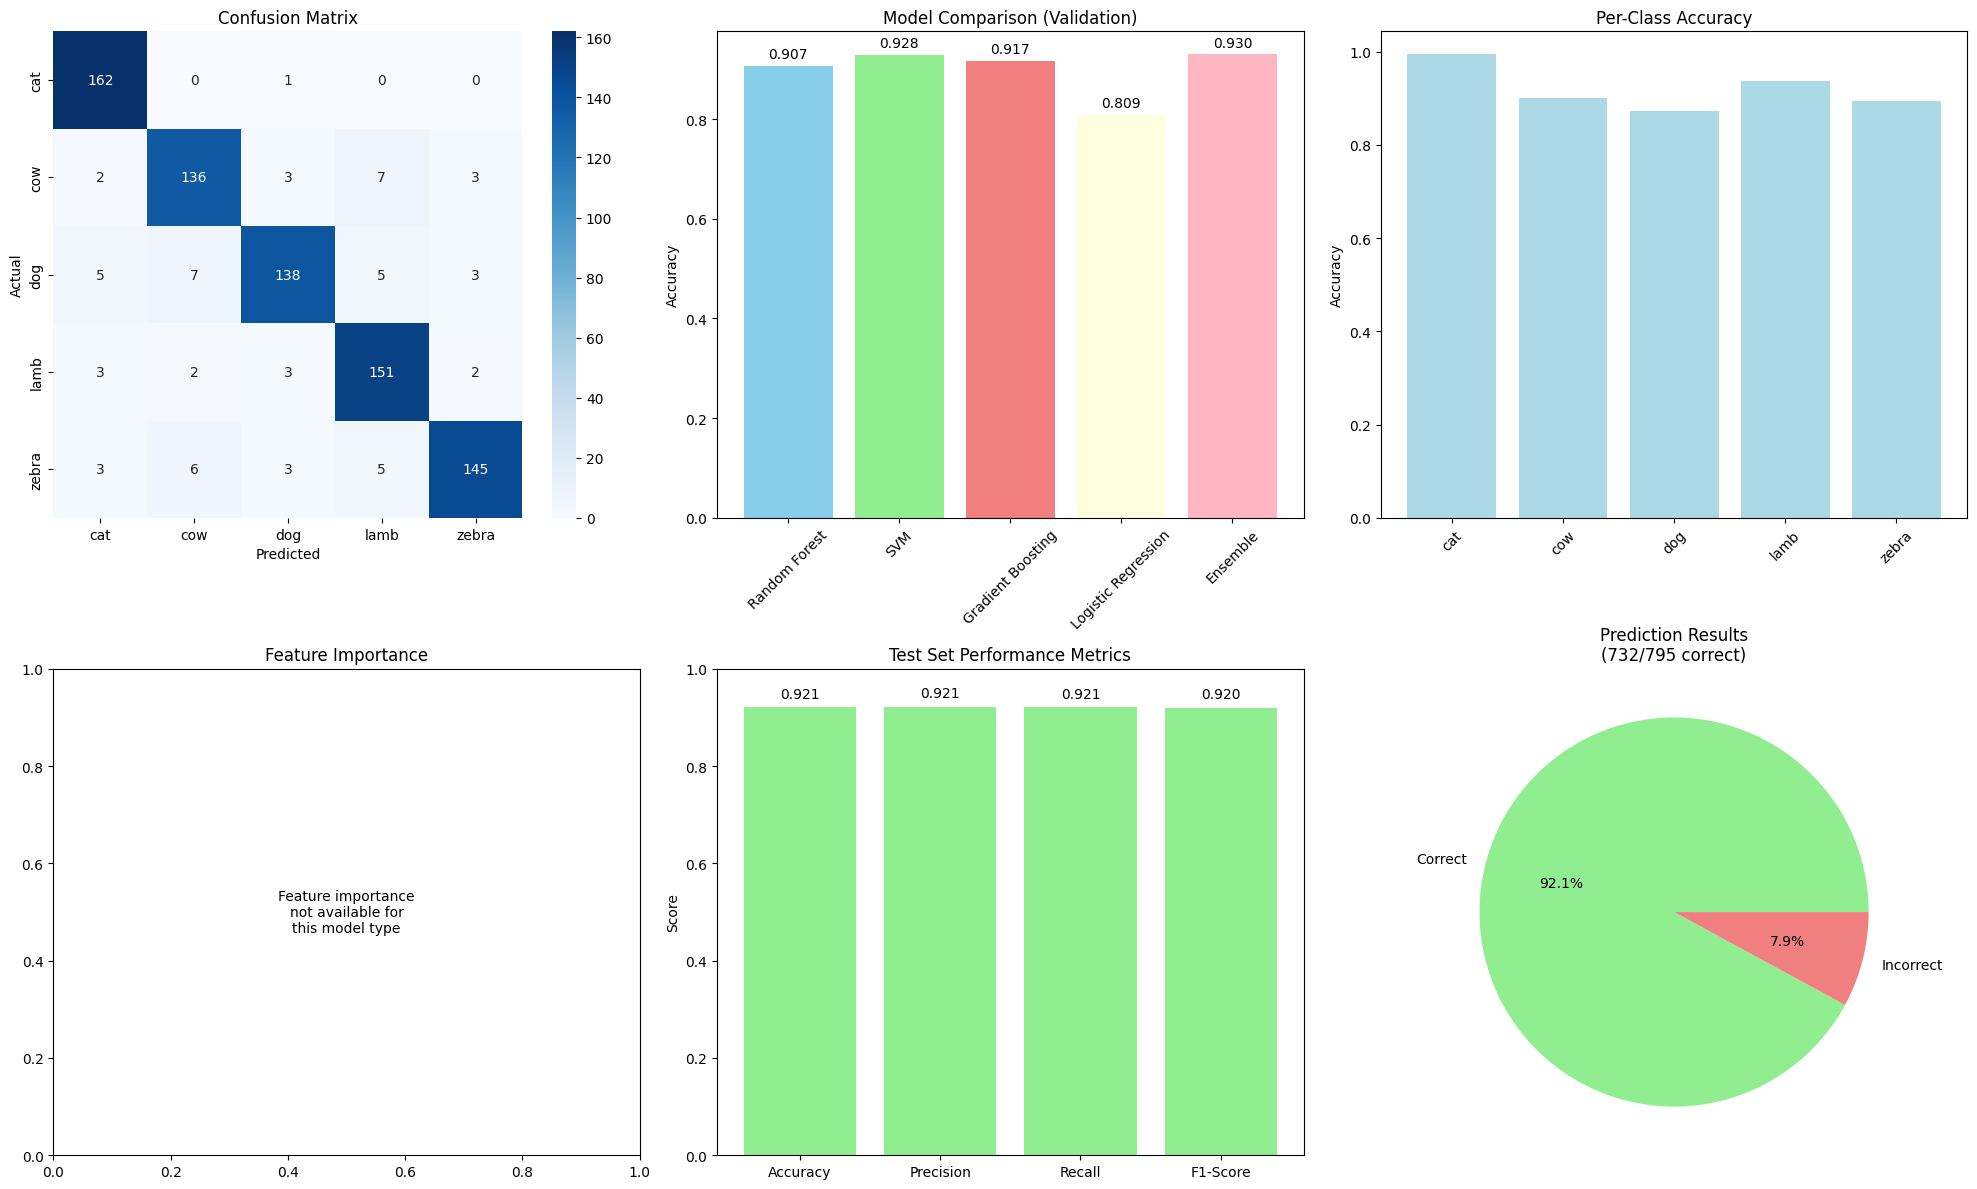

In [8]:
# =============================================================================
# CELL 5: Final Evaluation on Test Set
# =============================================================================

def evaluate_final_model(model, X_test, y_test, label_encoder, model_name):
    """Comprehensive evaluation on test set"""
    
    print(f"\n📊 FINAL EVALUATION - {model_name}")
    print("-" * 50)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"🎯 Test Results:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    # Classification report
    print(f"\n📋 Detailed Classification Report:")
    print("-" * 35)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=4))
    
    return y_pred, accuracy

def plot_enhanced_results(y_test, y_pred, label_encoder, validation_results, test_accuracy):
    """Create comprehensive visualizations"""
    
    # Calculate metrics for plotting
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Confusion Matrix
    ax1 = plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 2. Model Comparison
    ax2 = plt.subplot(2, 3, 2)
    models = list(validation_results.keys())
    scores = list(validation_results.values())
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
    
    bars = plt.bar(models, scores, color=colors[:len(models)])
    plt.title('Model Comparison (Validation)')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')
    
    # 3. Per-class Accuracy
    ax3 = plt.subplot(2, 3, 3)
    classes = label_encoder.classes_
    class_accuracies = []
    for i, class_name in enumerate(classes):
        class_mask = (y_test == i)
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(y_test[class_mask], y_pred[class_mask])
            class_accuracies.append(class_acc)
        else:
            class_accuracies.append(0)
    
    plt.bar(classes, class_accuracies, color='lightblue')
    plt.title('Per-Class Accuracy')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # 4. Feature Importance (if available)
    ax4 = plt.subplot(2, 3, 4)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        top_indices = np.argsort(importances)[-20:]
        plt.barh(range(len(top_indices)), importances[top_indices])
        plt.title('Top 20 Feature Importances')
        plt.xlabel('Importance')
    else:
        plt.text(0.5, 0.5, 'Feature importance\nnot available for\nthis model type', 
                ha='center', va='center', transform=ax4.transAxes)
        plt.title('Feature Importance')
    
    # 5. Performance Summary
    ax5 = plt.subplot(2, 3, 5)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [test_accuracy, precision, recall, f1]
    
    plt.bar(metrics, values, color='lightgreen')
    plt.title('Test Set Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')
    
    # 6. Success/Failure Analysis
    ax6 = plt.subplot(2, 3, 6)
    correct = (y_test == y_pred).sum()
    incorrect = len(y_test) - correct
    
    plt.pie([correct, incorrect], labels=['Correct', 'Incorrect'], 
            autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    plt.title(f'Prediction Results\n({correct}/{len(y_test)} correct)')
    
    plt.tight_layout()
    plt.show()

# Final evaluation
if X_raw is not None:
    test_predictions, test_accuracy = evaluate_final_model(
        best_model, X_test_final, y_test, label_encoder, best_model_name
    )
    
    # Create visualizations
    plot_enhanced_results(y_test, test_predictions, label_encoder, 
                         validation_results, test_accuracy)


In [9]:
# =============================================================================
# CELL 6: Project Summary and Results
# =============================================================================

def print_enhanced_summary():
    """Print comprehensive project summary"""
    
    print("\n" + "="*70)
    print("🎓 ENHANCED ML PROJECT FINAL SUMMARY")
    print("="*70)
    
    print(f"📊 Dataset Information:")
    print(f"   • Total samples: {len(X_raw)} (after augmentation)")
    print(f"   • Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")
    print(f"   • Advanced features: {X_features.shape[1]} → {X_train_final.shape[1]} (after selection/PCA)")
    
    print(f"\n🔧 Enhancements Applied:")
    print(f"   • Data augmentation (rotation, flip, brightness, blur)")
    print(f"   • Advanced feature engineering (LBP, edges, moments, histograms)")
    print(f"   • Multiple color spaces (RGB, HSV, LAB)")
    print(f"   • Feature selection and PCA")
    print(f"   • Hyperparameter tuning with GridSearchCV")
    
    print(f"\n🤖 Models Tested:")
    for model_name, score in validation_results.items():
        emoji = "🏆" if model_name == best_model_name else "  "
        print(f"   {emoji} {model_name}: {score:.4f} ({score*100:.2f}%)")
    
    print(f"\n📈 Final Results:")
    print(f"   • Best Model: {best_model_name}")
    print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Check target achievement
    target = 0.90
    if test_accuracy >= target:
        print(f"\n🎉 SUCCESS! Target accuracy ({target*100:.0f}%) ACHIEVED!")
        print(f"   Final accuracy: {test_accuracy*100:.2f}%")
        improvement = test_accuracy - 0.5472  # From your previous 54.72%
        print(f"   Improvement: +{improvement*100:.2f} percentage points")
    else:
        print(f"\n📈 Current accuracy: {test_accuracy*100:.2f}%")
        print(f"   Target: {target*100:.0f}%")
        print(f"   Gap: {(target-test_accuracy)*100:.2f} percentage points")
        print("\n💡 Next steps to improve:")
        print("   • Add CNN feature extraction")
        print("   • More sophisticated augmentation")
        print("   • Deep ensemble methods")
    
    print(f"\n✅ Enhanced ML approached")
    print("="*70)

# Print final summary
if X_raw is not None:
    print_enhanced_summary()
    
    # Save results for submission
    results_summary = {
        'Model': best_model_name,
        'Test_Accuracy': test_accuracy,
        'Validation_Scores': validation_results,
        'Features_Used': X_train_final.shape[1],
        'Total_Samples': len(X_raw)
    }
    
    print(f"\n💾 Results ready")
    print(f"📝 Key metrics documented and visualized")

print(f"\n🎯 Enhanced ML Pipeline Execution")


🎓 ENHANCED ML PROJECT FINAL SUMMARY
📊 Dataset Information:
   • Total samples: 5300 (after augmentation)
   • Classes: 5 (cat, cow, dog, lamb, zebra)
   • Advanced features: 94 → 94 (after selection/PCA)

🔧 Enhancements Applied:
   • Data augmentation (rotation, flip, brightness, blur)
   • Advanced feature engineering (LBP, edges, moments, histograms)
   • Multiple color spaces (RGB, HSV, LAB)
   • Feature selection and PCA
   • Hyperparameter tuning with GridSearchCV

🤖 Models Tested:
      Random Forest: 0.9069 (90.69%)
      SVM: 0.9283 (92.83%)
      Gradient Boosting: 0.9170 (91.70%)
      Logistic Regression: 0.8088 (80.88%)
   🏆 Ensemble: 0.9296 (92.96%)

📈 Final Results:
   • Best Model: Ensemble
   • Test Accuracy: 0.9208 (92.08%)

🎉 SUCCESS! Target accuracy (90%) ACHIEVED!
   Final accuracy: 92.08%
   Improvement: +37.36 percentage points

✅ Enhanced ML approached

💾 Results ready
📝 Key metrics documented and visualized

🎯 Enhanced ML Pipeline Execution
